In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df1 = pd.read_csv(r"C:\Users\ehowi\Downloads\securities.csv")

In [3]:
df2 = pd.read_csv(r"C:\Users\ehowi\Downloads\prices.csv")

In [4]:
df1 = pd.concat([df1,df2])

In [5]:
df2['Daily Return'] = df2['close'] - df2['open']
df2['WentUp?'] = df2['Daily Return'] > 0

In [6]:
def add_moving_averages(df, column='Close', sma_window=5, ema_window=10):

    df[f'SMA_{sma_window}'] = df.groupby('symbol')[column].transform(lambda x: x.shift(1).rolling(window=sma_window).mean())
    df[f'EMA_{ema_window}'] = df.groupby('symbol')[column].transform(lambda x: x.shift(1).ewm(span=ema_window, adjust=False).mean())


    return df
def add_rsi(df, column='Close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, column='Close', short_window=12, long_window=26, signal_window=9):
    df['MACD_line'] = df[column].ewm(span=short_window, adjust=False).mean() - df[column].ewm(span=long_window, adjust=False).mean()
    df['MACD_signal'] = df['MACD_line'].ewm(span=signal_window, adjust=False).mean()
    return df

In [7]:
add_moving_averages(df2, column='close', sma_window=5, ema_window=10)
#add_moving_averages(df2, column='close', sma_window=7, ema_window=3)
add_moving_averages(df2, column='close', sma_window=3, ema_window=5)
add_moving_averages(df2, column='close', sma_window=20, ema_window=50)
#add_rsi(df2, column='close', window=14)
#add_macd(df2, column='close', short_window=12, long_window=26, signal_window=9)

,date,symbol,open,close,low,high,volume,Daily Return,WentUp?,SMA_5,EMA_10,SMA_3,EMA_5,SMA_20,EMA_50
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996,True,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995,False,NaN,125.839996,NaN,125.839996,NaN,125.839996
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000,False,NaN,124.774543,NaN,123.886665,NaN,125.610192
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000,True,NaN,122.988262,120.256665,120.907776,NaN,125.192145
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,False,NaN,121.830396,117.183334,119.478518,NaN,124.855983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,False,102.717999,102.965500,103.233332,102.985531,103.182000,107.187280
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,False,43.520001,43.131082,43.333333,43.287669,42.577500,38.929703
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,False,53.563999,53.013153,53.593333,53.453788,51.857499,51.276696
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,True,44.506001,44.136159,44.413334,44.443135,43.255500,43.176413


In [8]:
df2['Yesterday High'] = df2.groupby('symbol')['high'].shift(1)
df2['Yesterday Low'] = df2.groupby('symbol')['low'].shift(1)
#df2['Yesterday return'] = df2.groupby('symbol')['Daily Return'].shift(1)
df2['Two Days Ago High'] = df2.groupby('symbol')['high'].shift(2)
df2['Two Days Ago Low'] = df2.groupby('symbol')['low'].shift(2)
#df2['Two Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(2)
df2['Three Days Ago High'] = df2.groupby('symbol')['high'].shift(3)
df2['Three Days Ago Low'] = df2.groupby('symbol')['low'].shift(3)
#df2['Three Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(3)
df2['Four Days Ago High'] = df2.groupby('symbol')['high'].shift(4)
df2['Four Days Ago Low'] = df2.groupby('symbol')['low'].shift(4)
#df2['Four Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(4)
df2.isnull().sum()
df2.dropna(inplace=True)
df2.shape

(841244, 23)

In [9]:
df2.head

<bound method NDFrame.head of                        date symbol        open       close         low  \
20      2016-02-03 00:00:00   WLTW  113.379997  114.050003  109.639999   
21      2016-02-04 00:00:00   WLTW  114.080002  115.709999  114.080002   
22      2016-02-05 00:00:00   WLTW  115.120003  114.019997  109.709999   
23      2016-02-08 00:00:00   WLTW  113.300003  111.160004  110.459999   
24      2016-02-09 00:00:00   WLTW  111.169998  110.650002  109.639999   
...                     ...    ...         ...         ...         ...   
851259           2016-12-30    ZBH  103.309998  103.199997  102.849998   
851260           2016-12-30   ZION   43.070000   43.040001   42.689999   
851261           2016-12-30    ZTS   53.639999   53.529999   53.270000   
851262  2016-12-30 00:00:00    AIV   44.730000   45.450001   44.410000   
851263  2016-12-30 00:00:00    FTV   54.200001   53.630001   53.389999   

              high     volume  Daily Return  WentUp?       SMA_5  ...  \
20      

In [10]:
df1.isnull().sum()

Ticker symbol              851264
Security                   851264
SEC filings                851264
GICS Sector                851264
GICS Sub Industry          851264
Address of Headquarters    851264
Date first added           851462
CIK                        851264
date                          505
symbol                        505
open                          505
close                         505
low                           505
high                          505
volume                        505
dtype: int64

In [11]:
df2

,date,symbol,open,close,low,high,volume,Daily Return,WentUp?,SMA_5,...,SMA_20,EMA_50,Yesterday High,Yesterday Low,Two Days Ago High,Two Days Ago Low,Three Days Ago High,Three Days Ago Low,Four Days Ago High,Four Days Ago Low
20,2016-02-03 00:00:00,WLTW,113.379997,114.050003,109.639999,114.639999,896300.0,0.670006,True,112.564000,...,113.662000,118.851887,113.860001,109.750000,114.849998,112.900002,114.589996,111.669998,112.970001,109.900002
21,2016-02-04 00:00:00,WLTW,114.080002,115.709999,114.080002,116.320000,956300.0,1.629997,True,113.232001,...,113.072500,118.663578,114.639999,109.639999,113.860001,109.750000,114.849998,112.900002,114.589996,111.669998
22,2016-02-05 00:00:00,WLTW,115.120003,114.019997,109.709999,116.489998,997100.0,-1.100006,False,113.858000,...,112.859000,118.547751,116.320000,114.080002,114.639999,109.639999,113.860001,109.750000,114.849998,112.900002
23,2016-02-08 00:00:00,WLTW,113.300003,111.160004,110.459999,113.300003,1200500.0,-2.139999,False,113.767999,...,112.812500,118.370192,116.489998,109.709999,116.320000,114.080002,114.639999,109.639999,113.860001,109.750000
24,2016-02-09 00:00:00,WLTW,111.169998,110.650002,109.639999,112.110001,1725200.0,-0.519996,False,113.100000,...,112.539500,118.087439,113.300003,110.459999,116.489998,109.709999,116.320000,114.080002,114.639999,109.639999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,False,102.717999,...,103.182000,107.187280,103.739998,102.830002,104.199997,102.839996,103.389999,101.980003,102.699997,101.430000
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,False,43.520001,...,42.577500,38.929703,43.639999,42.630001,44.029999,43.180000,44.150002,43.669998,43.939999,43.590000
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,False,53.563999,...,51.857499,51.276696,53.779999,53.400002,53.849998,53.349998,54.150002,53.650002,53.779999,53.180000
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,True,44.506001,...,43.255500,43.176413,44.840000,44.250000,44.450001,44.000000,44.939999,44.240002,44.910000,44.480000


In [12]:
AAPL = df2[df2['symbol'] == 'AAPL']

In [13]:
scaler= StandardScaler()

In [14]:
x = pd.DataFrame(AAPL.drop(columns = ["WentUp?"]))
x = pd.DataFrame(x.drop(columns = ["date"]))
x = pd.DataFrame(x.drop(columns = ["symbol"]))
x = pd.DataFrame(x.drop(columns = ["close"]))
x = pd.DataFrame(x.drop(columns = ["high"]))
x = pd.DataFrame(x.drop(columns = ["low"]))
x = pd.DataFrame(x.drop(columns = ["Daily Return"]))
y = AAPL["WentUp?"]

In [15]:
x

,open,volume,SMA_5,EMA_10,SMA_3,EMA_5,SMA_20,EMA_50,Yesterday High,Yesterday Low,Two Days Ago High,Two Days Ago Low,Three Days Ago High,Three Days Ago Low,Four Days Ago High,Four Days Ago Low
9613,195.909998,174585600.0,199.980000,201.715217,195.359999,198.202921,207.0660,209.534026,196.000000,191.299999,202.199995,190.250002,205.500004,198.699995,210.580000,199.530001
10081,195.169994,153832000.0,197.964000,200.650631,194.216666,197.421947,206.1585,208.997790,196.319994,193.379993,196.000000,191.299999,202.199995,190.250002,205.500004,198.699995
10549,196.730003,189413000.0,196.233997,200.392334,196.606663,198.024629,205.4010,208.614739,200.200003,194.420004,196.319994,193.379993,196.000000,191.299999,202.199995,190.250002
11017,192.630003,212576700.0,194.785999,198.875546,195.713331,196.033087,204.4550,207.965142,198.370001,191.570005,200.200003,194.420004,196.319994,193.379993,196.000000,191.299999
11485,195.690006,119567700.0,195.465999,198.254538,195.579999,195.842058,203.6990,207.474744,196.000000,190.850002,198.370001,191.570005,200.200003,194.420004,196.319994,193.379993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848767,115.589996,14249500.0,116.581999,115.418528,116.766665,116.345562,113.1650,112.601607,116.510002,115.639999,117.400002,116.779999,117.500000,116.680000,117.379997,115.750000
849267,116.519997,18296900.0,116.691998,115.618795,116.623332,116.403707,113.4015,112.755270,116.519997,115.589996,116.510002,115.639999,117.400002,116.779999,117.500000,116.680000
849767,117.519997,20905900.0,116.815999,115.917196,116.690000,116.689139,113.6860,112.931926,117.800003,116.489998,116.519997,115.589996,116.510002,115.639999,117.400002,116.779999
850267,116.449997,15039500.0,116.778000,116.070434,116.846667,116.712760,113.9510,113.082046,118.019997,116.199997,117.800003,116.489998,116.519997,115.589996,116.510002,115.639999


In [16]:
X_scaled = scaler.fit_transform(x)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
param_grid = {
 'n_neighbors': [3, 5, 7, 9, 11, 13, 15],        
# Regularization parameter
 'weights': ['uniform', 'distance'],  # Kernel coefficient
 'metric': ['euclidean', 'manhattan','minkowski'],    
 'p': [1, 2] # power parameter for Minkowski distance   
}

In [20]:
model = KNeighborsClassifier()

In [21]:
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv=kfold, scoring='accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [22]:
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

Best Cross-Validation Accuracy: 0.5154328150382919
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


In [23]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [24]:
print("R-Squared:", r2_score(y_test, y_pred))

R-Squared: -0.8571147024044146


In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.53      0.48      0.50       172
        True       0.54      0.59      0.56       177

    accuracy                           0.54       349
   macro avg       0.54      0.53      0.53       349
weighted avg       0.54      0.54      0.53       349



Classification Report:
              precision    recall  f1-score   support

       False       0.53      0.48      0.50       172
        True       0.54      0.59      0.56       177

    accuracy                           0.54       349
   macro avg       0.54      0.53      0.53       349
weighted avg       0.54      0.54      0.53       349



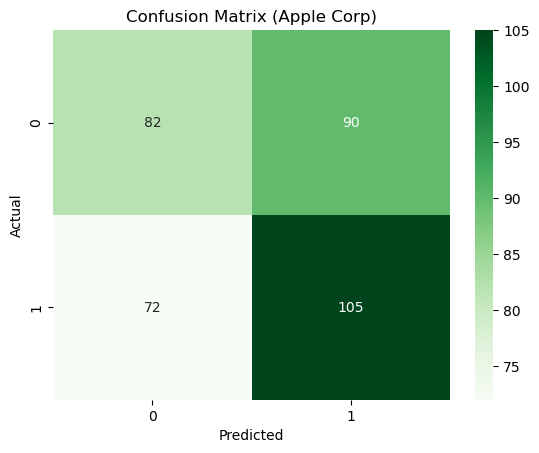

In [54]:
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
        plt.title(f'Confusion Matrix (Apple Corp)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()